In [29]:
import json
import math
import random
from pathlib import Path
from pprint import pprint
from utils import load_dataset, create_dataset, in_context_from_samples, test_prompt_from_samples, gpt_prediction, eval_response, results_path

In [30]:
output_dir = results_path / "sentence_lenpar_all_caps"
if not output_dir.exists():
    output_dir.mkdir(parents=True)
dataset, tag_counts = load_dataset("sentences.json")
print(len(dataset))
pprint(tag_counts)

200
{'all_lower': 67,
 'all_upper': 59,
 'city': 25,
 'even_words': 97,
 'fragment_subject': 20,
 'fragment_verb': 20,
 'gpt4': 200,
 'nature': 62,
 'odd_words': 103,
 'proper_noun': 32,
 'sentence': 160,
 'shared_sample': 42,
 'start_cap': 133,
 'start_lower': 67,
 'start_the': 57}


In [31]:
# fragments vs sentence; just subject/verb fragments vs all; test if class balance changes accuracy
tags_true = ["sentence"]
tags_false = ["fragment_subject", "fragment_verb"]
tags_common = ["sentence"]
positives, negatives = create_dataset(dataset, tags_true, tags_false, tags_common)

with open(output_dir / "dataset_tags.txt", "w") as f:
    f.write(f"tags_true: {tags_true}\n")
    f.write(f"tags_false: {tags_false}\n")
    f.write(f"tags_common: {tags_common}\n")

In [32]:
pprint(sorted(positives, key=lambda x: "all_upper" not in x["tags"]))

[{'input': 'THE MOUNTAINS ARE MAJESTIC AND GRAND.',
  'label': True,
  'tags': ['start_cap',
           'all_upper',
           'sentence',
           'shared_sample',
           'nature',
           'even_words',
           'start_the',
           'gpt4']},
 {'input': 'THERE IS NOTHING EITHER GOOD OR BAD, BUT THINKING MAKES IT SO.',
  'label': True,
  'tags': ['start_cap', 'all_upper', 'sentence', 'even_words', 'gpt4']},
 {'input': 'IN THE END, WE WILL REMEMBER NOT THE WORDS OF OUR ENEMIES, BUT THE '
           'SILENCE OF OUR FRIENDS.',
  'label': True,
  'tags': ['start_cap', 'all_upper', 'sentence', 'even_words', 'gpt4']},
 {'input': 'CURIOSITY LEADS TO DISCOVERY.',
  'label': True,
  'tags': ['start_cap', 'all_upper', 'sentence', 'even_words', 'gpt4']},
 {'input': 'PATIENCE IS A VIRTUE.',
  'label': True,
  'tags': ['start_cap', 'all_upper', 'sentence', 'even_words', 'gpt4']},
 {'input': 'WINTER BRINGS SNOW AND FROSTY MORNINGS.',
  'label': True,
  'tags': ['start_cap',
          

In [33]:
pprint(negatives)

[{'input': 'The Golden Gate Bridge spans the San Francisco Bay.',
  'label': False,
  'tags': ['start_the',
           'start_cap',
           'city',
           'sentence',
           'odd_words',
           'gpt4',
           'proper_noun']},
 {'input': 'the aroma of fresh bread is irresistible.',
  'label': False,
  'tags': ['start_the',
           'all_lower',
           'sentence',
           'odd_words',
           'start_lower',
           'gpt4']},
 {'input': 'HAPPINESS IS A WARM CUP OF TEA.',
  'label': False,
  'tags': ['start_cap',
           'all_upper',
           'sentence',
           'shared_sample',
           'odd_words',
           'gpt4']},
 {'input': 'butterflies dance in the garden.',
  'label': False,
  'tags': ['all_lower',
           'sentence',
           'nature',
           'odd_words',
           'start_lower',
           'gpt4']},
 {'input': 'oceans hide countless wonders beneath the surface.',
  'label': False,
  'tags': ['all_lower',
           'sentence

In [34]:
samples_per_label = 5
num_test_samples = 40

positives = sorted(positives, key=lambda x: "all_upper" not in x["tags"])
negatives = sorted(negatives, key=lambda x: "all_upper" not in x["tags"])

in_context_samples = positives[:samples_per_label] + negatives[:samples_per_label]
in_context_prompt = in_context_from_samples(in_context_samples)
with open(output_dir / "in_context_prompt.txt", "w") as f:
    f.write(in_context_prompt)

from random import shuffle
test_positives = positives[samples_per_label:]
test_negatives = negatives[samples_per_label:]
shuffle(test_positives), shuffle(test_negatives)
test_prompt, test_samples = test_prompt_from_samples(test_positives, test_negatives)
with open(output_dir / "test_prompt.txt", "w") as f:
    f.write(test_prompt)
json.dump(test_samples, open(output_dir / "test_samples.json", "w"), indent=2)

In [36]:
temperatures = [0.1, 0.5, 1, 1.25, 1.5, 2]
response_jsons = []
in_context_prompt = open(output_dir / "in_context_prompt.txt").read()
test_prompt = open(output_dir / "test_prompt.txt").read()
test_samples = json.load(open(output_dir / "test_samples.json"))
for t in temperatures:
    response_json = gpt_prediction(in_context_prompt, test_prompt, temperature=t, json_mode=True)
    json.dump(response_json, open(output_dir / f"response_{t}.json", "w"))
    response_jsons.append(response_json)

/Users/ishangaur/classification-faithfulness/utils.py:88: UserWarning: json_mode only supported for gpt-4-1106-preview
  warn("json_mode only supported for gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:89: UserWarning: changing model to gpt-4-1106-preview
  warn("changing model to gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:92: UserWarning: json_mode is on but user_query does not contain "json"
  warn("json_mode is on but user_query does not contain \"json\"")
/Users/ishangaur/classification-faithfulness/utils.py:93: UserWarning: adding prefix to user_query:
"Please label the following inputs. Respond in JSON format like the examples given to you above."
  warn(f"adding prefix to user_query:\n\"{json_prefix}\"")


In [ ]:
temperatures = [0.1, 0.5, 1, 1.25, 1.5, 2]
response_jsons = [json.load(open(output_dir / f"response_{t}.json")) for t in temperatures]
test_samples = json.load(open(output_dir / "test_samples.json"))

results = []
responses = []
for r in response_jsons:
    response, result = eval_response(r, test_samples)
    results.append(result)
    responses.append(response)

/Users/ishangaur/classification-faithfulness/utils.py:151: UserWarning: Something went wrong with eval_response.              The sum of correct, mismatch, and incorrect should equal the number of test samples.
  warn("Something went wrong with eval_response. \
/Users/ishangaur/classification-faithfulness/utils.py:138: UserWarning: Response sample is not a dict or does not contain "label" and "input"
  warn("Response sample is not a dict or does not contain \"label\" and \"input\"")
/Users/ishangaur/classification-faithfulness/utils.py:139: UserWarning: Response sample: {'input': 'Mount Everest is t... (Only the first 90 '}
  warn(f"Response sample: {r_sample}")
/Users/ishangaur/classification-faithfulness/utils.py:139: UserWarning: Response sample: {'input': 'A quiet alley'}
  warn(f"Response sample: {r_sample}")
/Users/ishangaur/classification-faithfulness/utils.py:139: UserWarning: Response sample: {'label': True}
  warn(f"Response sample: {r_sample}")
/Users/ishangaur/classificatio

In [ ]:
for t, r in zip(temperatures, results):
    r["temp"] = t
pprint(results)

[{'accuracy': 0.5,
  'correct': 75,
  'corrupted': 0,
  'incorrect': 75,
  'mismatch': 0,
  'temp': 0.1,
  'total': 150},
 {'accuracy': 0.5,
  'correct': 75,
  'corrupted': 0,
  'incorrect': 75,
  'mismatch': 0,
  'temp': 0.5,
  'total': 150},
 {'accuracy': 0.08,
  'correct': 12,
  'corrupted': 0,
  'incorrect': 8,
  'mismatch': 0,
  'temp': 1,
  'total': 150},
 {'accuracy': 0.22666666666666666,
  'correct': 34,
  'corrupted': 1,
  'incorrect': 26,
  'mismatch': 0,
  'temp': 1.25,
  'total': 150},
 {'accuracy': 0.08,
  'correct': 12,
  'corrupted': 0,
  'incorrect': 8,
  'mismatch': 0,
  'temp': 1.5,
  'total': 150},
 {'accuracy': 0.0,
  'correct': 0,
  'corrupted': 6,
  'incorrect': 0,
  'mismatch': 0,
  'temp': 2,
  'total': 150}]


In [ ]:
json.dump(responses, open(output_dir / "responses.json", "w"))
json.dump(results, open(output_dir / "results.json", "w"))

       correct  mismatch  incorrect  corrupted
temp                                          
0.10  0.500000       0.0   0.500000   0.000000
0.50  0.500000       0.0   0.500000   0.000000
1.00  0.080000       0.0   0.053333   0.000000
1.25  0.226667       0.0   0.173333   0.006667
1.50  0.080000       0.0   0.053333   0.000000
2.00  0.000000       0.0   0.000000   0.040000


Text(0.5, 1.0, 'Sentence Length Parity (n=150, pos=79, neg=71; )')

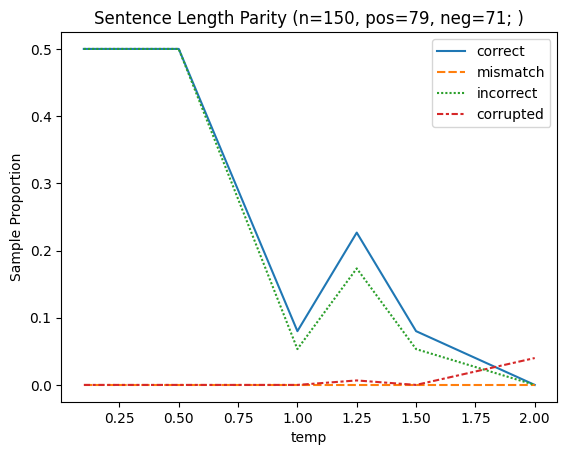

In [ ]:
import pandas as pd
import seaborn as sns

results = json.load(open(output_dir / "results.json"))

test_samples = json.load(open(output_dir / "test_samples.json"))
total_samples = len(test_samples)
pos_samples = len([s for s in test_samples if s["label"]])
neg_samples = total_samples - pos_samples

df = pd.DataFrame(results)
df.drop(columns=["accuracy"], inplace=True)

for col in df.columns:
    df[col] /= df["total"]
df.drop(columns=["total"], inplace=True)
df.set_index("temp", inplace=True)
print(df)

ax = sns.lineplot(data=df)
ax.set_ylabel("Sample Proportion")
ax.set_title(f"Sentence Length Parity (n={total_samples}, pos={pos_samples}, neg={neg_samples}; )")